# Using `GMMHMM` & `HMMClassifier`

This notebook aims to showcase how Sequentia's implementation of a HMM classifier can be used in a typical sequence classisfication task. 

In particular, we look at the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset), which is an open dataset consisting of audio recordings of spoken digits from 0 to 9. We are interested in the task of determining which digit was spoken based on the audio recordings. Since audio signals are sequential data, we can consider this as a sequence classification problem.

In [1]:
import librosa, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm.auto import tqdm

from sequentia.preprocessing import Compose, Custom, Standardize
from sequentia.classifiers import GMMHMM, HMMClassifier
from sequentia.datasets import load_digits

from nbutils import play_audio

# Set seed for reproducible randomness
random_state = np.random.RandomState(1)

To get started, we first decide to use [Mel-Frequency Cepstrum Coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), which are a common way to represent audio for machine learning. 

While there are methods that work directly with raw signals, the most common approach is to use transformed features such as MFCCs.

In short, MFCCs are used to characterize a particular window (usually 20-40ms) of samples of the original signal, by applying signal processing techniques and transformations to obtain a number of representative coefficients. The signal is divided into overlapping windows, and MFCCs are computed for each.

Below, we specify 5 MFCCs along with a number of other configurations for the MFCCs.

**Note**: 5 MFCCs is far less than what would be used in typical machine learning tasks, but we use a small number just for demonstration purposes.

In [2]:
# Set MFCC configuration
spec_kwargs = {'sr': 8000, 'n_mfcc': 5, 'n_fft': 1024, 'hop_length': 256, 'power': 2}

The below code loads the FSDD dataset and generates training and test set splits (80% and 20%, respectively).

In [3]:
# Load the FSDD dataset
dataset = load_digits(random_state=random_state)

In [4]:
# Split the dataset into a training and test dataset
train_set, test_set = dataset.split(split_size=0.2, stratify=True, shuffle=True)
print(f'Training set size: {len(train_set)}')
print(f'Test set size: {len(test_set)}')

Training set size: 2400
Test set size: 600


In [5]:
# Fetch the sequences and labels separately
X_train, y_train = train_set.data()
X_test, y_test = test_set.data()

We now define a transformation pipeline that generates and standardizes MFCCs using a custom transform involving the Librosa package and the `Standardize` transformation from Sequentia. This sequence of transformations is packaged into a `Compose` class, which acts in a similar way as [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Compose).

In [6]:
# Create preprocessing pipeline
transforms = Compose([
    Custom(lambda x: librosa.feature.mfcc(x.flatten(), **spec_kwargs).T, name='MFCCs', desc='Generate MFCCs'),
    Standardize()
])

transforms.summary()

                   Preprocessing summary:                   
1. Custom (MFCCs)
   Generate MFCCs
------------------------------------------------------------
2. Standardize
   Standard scaling (zero mean, unit variance) (independent)


We apply the same transformations to both the training and test sets.

In [7]:
mfcc_train = transforms(X_train)
mfcc_test = transforms(X_test)

The figure below shows the difference between the raw audio signal of the pronunciation of a digit 5, and the MFCC representation.

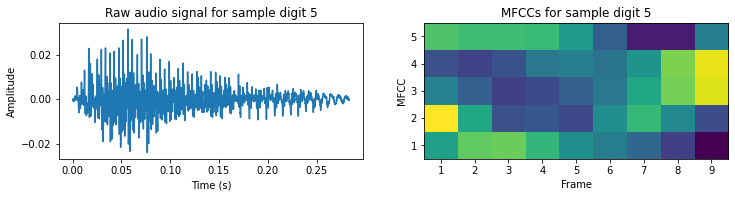

In [8]:
audio, mfcc, digit = X_train[0], mfcc_train[0], y_train[0]
time = np.linspace(0, len(audio) / spec_kwargs['sr'], num=len(audio))

# Raw audio
fig, axs = plt.subplots(ncols=2, figsize=(12, 2.5))
axs[0].set(title='Raw audio signal for sample digit {}'.format(digit), xlabel='Time (s)', ylabel='Amplitude')
axs[0].plot(time, audio)

# MFCCs
axs[1].imshow(np.swapaxes(mfcc, 0, 1), interpolation='nearest', cmap='viridis', origin='lower', aspect='auto')
axs[1].set(title='MFCCs for sample digit {}'.format(digit), xlabel='Frame', ylabel='MFCC',
    xticks=np.arange(len(mfcc)), xticklabels=np.arange(1, len(mfcc) + 1),
    yticks=np.arange(mfcc.shape[1]), yticklabels=np.arange(1, mfcc.shape[1] + 1))

plt.show()

Here is what the recording of this audio sounds like.

In [9]:
# Play the recording of the digit
play_audio(audio)

Now we create and fit our HMMs, **each being trained only to the observation sequences of the digit that it represents**. These models are combined to form one `HMMClassifier`. Each HMM has 3 states, and each state's multivariate Gaussian mixture emission distribution consists of 5 components.

Note that when fitting, we access the data through a helper function `train_set.iter_by_class()`, so we must first update the data stored in the `train_set` object to use MFCC values, otherwise we would be using the original unprocessed audio signals.

In [10]:
# Use preprocessed MFCC sequences instead of raw audio
train_set.X = mfcc_train

In [11]:
%%time

hmms = []
for sequences, label in tqdm(train_set.iter_by_class(), total=10, desc='Training HMMs'):
    # Create a linear HMM with 3 states and 5 components in the GMM emission state distributions
    hmm = GMMHMM(label=label, n_states=3, n_components=5, topology='linear', random_state=random_state)
    # Set random initial state distributions and transition matrix according to the linear topology
    hmm.set_random_initial()
    hmm.set_random_transitions()
    # Fit each HMM only on the observation sequences which had that label
    hmm.fit(sequences)
    hmms.append(hmm)
    
clf = HMMClassifier().fit(hmms)

Training HMMs:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2min 54s, sys: 16.2 s, total: 3min 10s
Wall time: 1min 47s


Finally, we evaluate the model on the test set and report accuracy and display a confusion matrix.

In [12]:
%%time

acc, cm = clf.evaluate(mfcc_test, y_test, verbose=False, n_jobs=-1)

CPU times: user 79.5 ms, sys: 59.3 ms, total: 139 ms
Wall time: 17.9 s


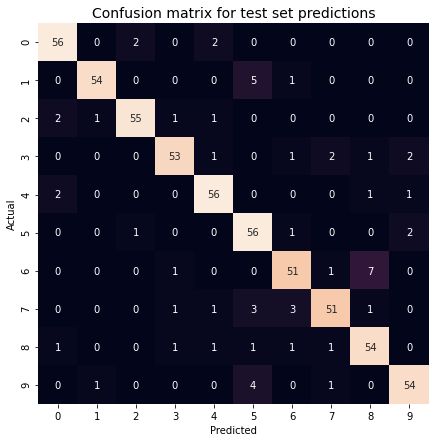

Accuracy: 90.00%


In [13]:
# Display accuracy and confusion matrix
labels = range(10)
df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(7, 7))
sns.heatmap(df, annot=True, cbar=False)
plt.title('Confusion matrix for test set predictions', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(f'Accuracy: {(acc * 100):.2f}%')